In [2]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.backend import get_session
tf.compat.v1.disable_v2_behavior()
from utils import process_dataframe, split_train_test, predict_index, get_X_y, scaler_function
shap.initjs()

In [3]:
stock = 'PRGS'
data = 'XGBoost10'
model = 'cnn_bigru'
trial_id = f'df_{stock}_{data}_{model}'
n_steps_in = 2
n_steps_out = 1
epoch = 1000
model = tf.keras.models.load_model(f'./outcome/gen_models/{trial_id}_{n_steps_in}_{n_steps_out}_{epoch-1}.h5', compile=False)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [4]:
dataframe = pd.read_feather(f'./data/{data}/df_{stock}_{data}.feather')

df = process_dataframe(dataframe)

X_value = pd.DataFrame(df.iloc[:, :])
y_value = pd.DataFrame(df.iloc[:, 0]) #first column is the closing price

n_features = X_value.shape[1]

X_train, X_test = split_train_test(X_value, train_dimension=0.8)
y_train, y_test = split_train_test(y_value.values, train_dimension=0.8)

X_scaler, y_scaler = scaler_function(X_train, y_train)
    
X_train = X_scaler.fit_transform(X_train)
y_train = y_scaler.fit_transform(y_train)
X_test = X_scaler.fit_transform(X_test)
y_test = y_scaler.fit_transform(y_test)

X_train, y_train, past_y_train = get_X_y(X_train, y_train, n_steps_in, n_steps_out)
X_test, y_test, past_y_test = get_X_y(X_test, y_test, n_steps_in, n_steps_out)

In [5]:
X_test.shape

(1105, 2, 19)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


Text(0.5, 1.0, 'PRGS')

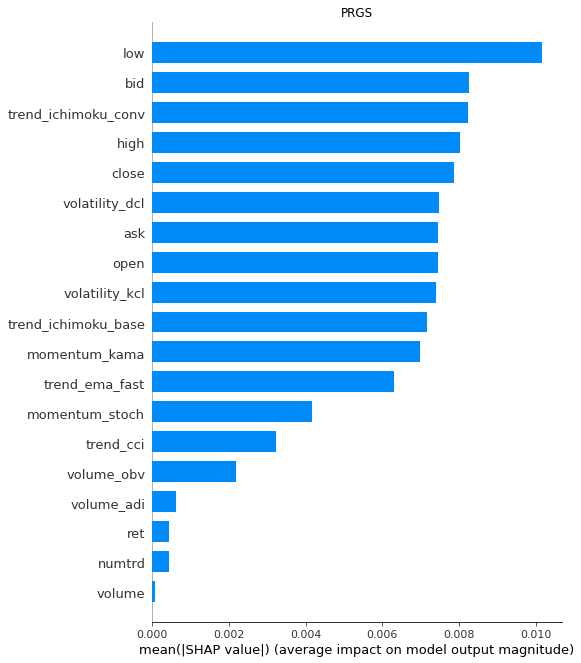

In [6]:
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.passthrough

explainer = shap.DeepExplainer(model, X_train)
shap_values = np.array(explainer.shap_values(X_test, check_additivity=False)).reshape(X_test.shape)
shap_values_2d = shap_values[:,0,:].reshape((X_test.shape[0],X_test.shape[2]))
X_test_2d = X_test[:,0,:].reshape((X_test.shape[0],X_test.shape[2]))

shap.summary_plot(shap_values_2d, X_test_2d, X_value.columns, max_display=20, plot_type="bar", show=False)
plt.title(f'{stock}')

In [7]:
# Across all out-of-sample observations
p = shap.force_plot(explainer.expected_value, shap_values_2d, X_test_2d, X_value.columns, show=False)
shap.save_html('my_force_plot.html', p)
p

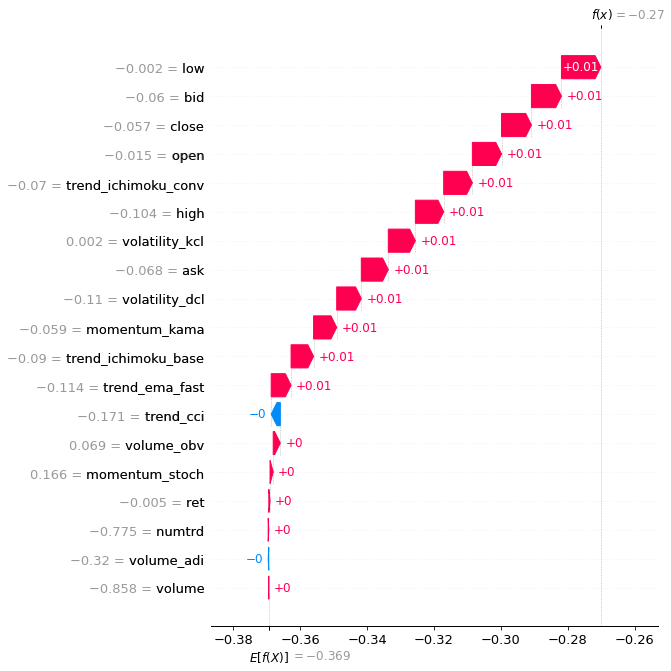

In [8]:
# Based on feature median
class ShapInput(object):
    def __init__(self, expectation, shap_values, features, feat_names, display_data):
        self.base_values = expectation
        self.values = shap_values
        self.data = features
        self.feature_names = feat_names
        self.display_data = display_data

shap_input = ShapInput(np.median(explainer.expected_value), np.median(shap_values_2d, axis=0), 
                       np.median(X_test_2d, axis=0), feat_names=X_value.columns, display_data=None)

shap.waterfall_plot(shap_input, max_display=20)